# 论文12：量子化学的神经消息传递
## Justin Gilmer, Samuel S. Schoenholz, Patrick F. Riley, Oriol Vinyals, George E. Dahl (2017)

### 消息传递神经网络（MPNNs）

图神经网络的统一框架。现代GNN的基础！

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 图表示 (Graph Representation)

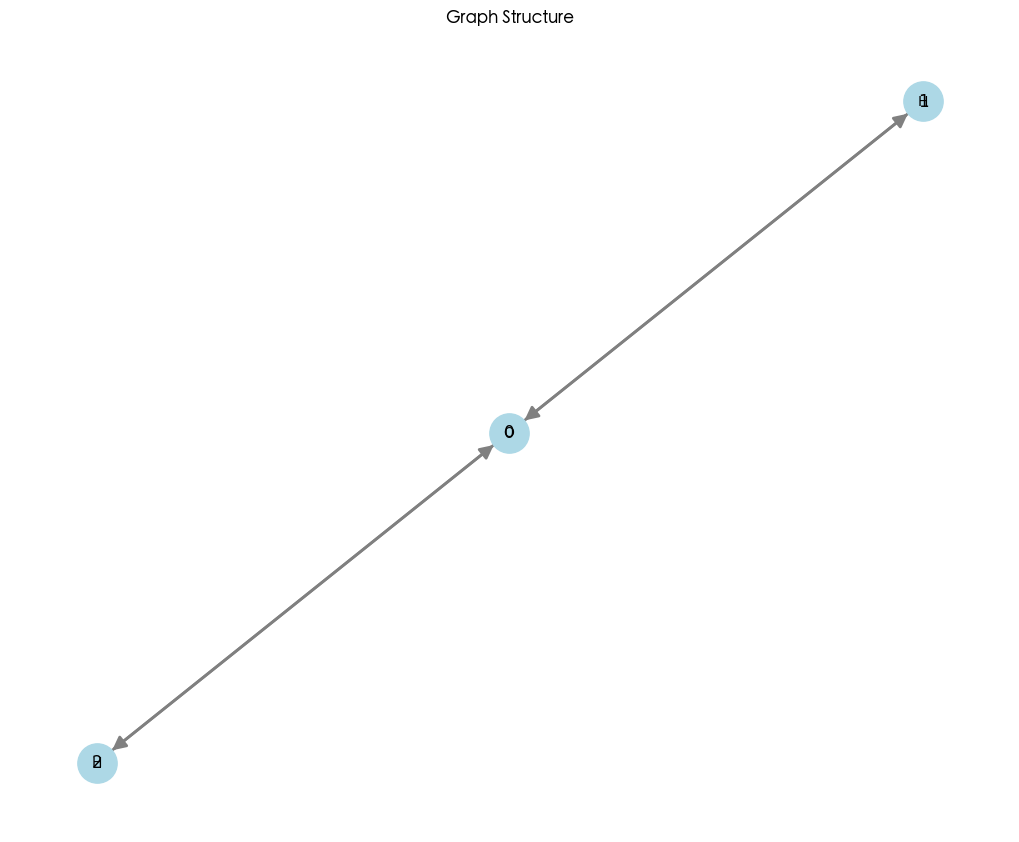

Number of nodes: 3
Number of edges: 4
Neighbors of node 0 (Oxygen): [1, 2]


In [2]:
class Graph:
    """Simple graph representation"""
    def __init__(self, num_nodes):
        self.num_nodes = num_nodes
        self.edges = []  # List of (source, target) tuples
        self.node_features = []  # List of node feature vectors
        self.edge_features = {}  # Dict: (src, tgt) -> edge features
    
    def add_edge(self, src, tgt, features=None):
        self.edges.append((src, tgt))
        if features is not None:
            self.edge_features[(src, tgt)] = features
    
    def set_node_features(self, features):
        """features: list of feature vectors"""
        self.node_features = features
    
    def get_neighbors(self, node):
        """Get all neighbors of a node"""
        neighbors = []
        for src, tgt in self.edges:
            if src == node:
                neighbors.append(tgt)
        return neighbors
    
    def visualize(self, node_labels=None):
        """Visualize graph using networkx"""
        G = nx.DiGraph()
        G.add_nodes_from(range(self.num_nodes))
        G.add_edges_from(self.edges)
        
        pos = nx.spring_layout(G, seed=42)
        
        plt.figure(figsize=(10, 8))
        nx.draw(G, pos, with_labels=True, node_color='lightblue', 
               node_size=800, font_size=12, arrows=True,
               arrowsize=20, edge_color='gray', width=2)
        
        if node_labels:
            nx.draw_networkx_labels(G, pos, node_labels, font_size=10)
        
        plt.title("Graph Structure")
        plt.axis('off')
        plt.show()

# Create sample molecular graph
# H2O (water): O connected to 2 H atoms
water = Graph(num_nodes=3)
water.add_edge(0, 1)  # O -> H
water.add_edge(0, 2)  # O -> H  
water.add_edge(1, 0)  # H -> O (undirected)
water.add_edge(2, 0)  # H -> O

# Node features: [atomic_num, valence, ...]
water.set_node_features([
    np.array([8, 2]),  # Oxygen
    np.array([1, 1]),  # Hydrogen
    np.array([1, 1]),  # Hydrogen
])

labels = {0: 'O', 1: 'H', 2: 'H'}
water.visualize(labels)

print(f"Number of nodes: {water.num_nodes}")
print(f"Number of edges: {len(water.edges)}")
print(f"Neighbors of node 0 (Oxygen): {water.get_neighbors(0)}")

## 消息传递框架 (Message Passing Framework)

**两个阶段：**
1. **消息传递**：从邻居聚合信息（T步）
2. **读出**：全局图表示

$$m_v^{t+1} = \sum_{w \in N(v)} M_t(h_v^t, h_w^t, e_{vw})$$
$$h_v^{t+1} = U_t(h_v^t, m_v^{t+1})$$

In [3]:
class MessagePassingLayer:
    """Single message passing layer"""
    def __init__(self, node_dim, edge_dim, hidden_dim):
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.hidden_dim = hidden_dim
        
        # Message function: M(h_v, h_w, e_vw)
        self.W_msg = np.random.randn(hidden_dim, 2*node_dim + edge_dim) * 0.01
        self.b_msg = np.zeros(hidden_dim)
        
        # Update function: U(h_v, m_v)
        self.W_update = np.random.randn(node_dim, node_dim + hidden_dim) * 0.01
        self.b_update = np.zeros(node_dim)
    
    def message(self, h_source, h_target, e_features):
        """Compute message from source to target"""
        # Concatenate source, target, edge features
        if e_features is None:
            e_features = np.zeros(self.edge_dim)
        
        concat = np.concatenate([h_source, h_target, e_features])
        
        # Apply message network
        message = np.tanh(np.dot(self.W_msg, concat) + self.b_msg)
        return message
    
    def aggregate(self, messages):
        """Aggregate messages (sum)"""
        if len(messages) == 0:
            return np.zeros(self.hidden_dim)
        return np.sum(messages, axis=0)
    
    def update(self, h_node, aggregated_message):
        """Update node representation"""
        concat = np.concatenate([h_node, aggregated_message])
        h_new = np.tanh(np.dot(self.W_update, concat) + self.b_update)
        return h_new
    
    def forward(self, graph, node_states):
        """
        One message passing step
        
        graph: Graph object
        node_states: list of current node hidden states
        
        Returns: updated node states
        """
        new_states = []
        
        for v in range(graph.num_nodes):
            # Collect messages from neighbors
            messages = []
            for w in graph.get_neighbors(v):
                # Get edge features
                edge_feat = graph.edge_features.get((w, v), None)
                
                # Compute message
                msg = self.message(node_states[w], node_states[v], edge_feat)
                messages.append(msg)
            
            # Aggregate messages
            aggregated = self.aggregate(messages)
            
            # Update node state
            h_new = self.update(node_states[v], aggregated)
            new_states.append(h_new)
        
        return new_states

# Test message passing
node_dim = 4
edge_dim = 2
hidden_dim = 8

mp_layer = MessagePassingLayer(node_dim, edge_dim, hidden_dim)

# Initialize node states from features
initial_states = []
for feat in water.node_features:
    # Embed to higher dimension
    state = np.concatenate([feat, np.zeros(node_dim - len(feat))])
    initial_states.append(state)

# Run message passing
updated_states = mp_layer.forward(water, initial_states)

print(f"\nInitial state (O): {initial_states[0]}")
print(f"Updated state (O): {updated_states[0]}")
print(f"\nNode states updated via neighbor information!")


Initial state (O): [8. 2. 0. 0.]
Updated state (O): [-0.00955206 -0.05902282 -0.00019007 -0.02271381]

Node states updated via neighbor information!


## 完整的MPNN (Complete MPNN)

In [4]:
class MPNN:
    """Message Passing Neural Network"""
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_dim, num_layers, output_dim):
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embed_W = np.random.randn(hidden_dim, node_feat_dim) * 0.01
        
        # Message passing layers
        self.mp_layers = [
            MessagePassingLayer(hidden_dim, edge_feat_dim, hidden_dim*2)
            for _ in range(num_layers)
        ]
        
        # Readout (graph-level prediction)
        self.readout_W = np.random.randn(output_dim, hidden_dim) * 0.01
        self.readout_b = np.zeros(output_dim)
    
    def forward(self, graph):
        """
        Forward pass through MPNN
        
        Returns: graph-level prediction
        """
        # Embed node features
        node_states = []
        for feat in graph.node_features:
            embedded = np.tanh(np.dot(self.embed_W, feat))
            node_states.append(embedded)
        
        # Message passing
        states_history = [node_states]
        for layer in self.mp_layers:
            node_states = layer.forward(graph, node_states)
            states_history.append(node_states)
        
        # Readout: aggregate node states to graph representation
        graph_repr = np.sum(node_states, axis=0)  # Simple sum pooling
        
        # Final prediction
        output = np.dot(self.readout_W, graph_repr) + self.readout_b
        
        return output, states_history

# Create MPNN
mpnn = MPNN(
    node_feat_dim=2,
    edge_feat_dim=2,
    hidden_dim=8,
    num_layers=3,
    output_dim=1  # Predict single property (e.g., energy)
)

# Forward pass
prediction, history = mpnn.forward(water)

print(f"Graph-level prediction: {prediction}")
print(f"(E.g., molecular property like energy, solubility, etc.)")

Graph-level prediction: [6.43890538e-08]
(E.g., molecular property like energy, solubility, etc.)


## 可视化消息传递 (Visualize Message Passing)

/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_63273/483051057.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


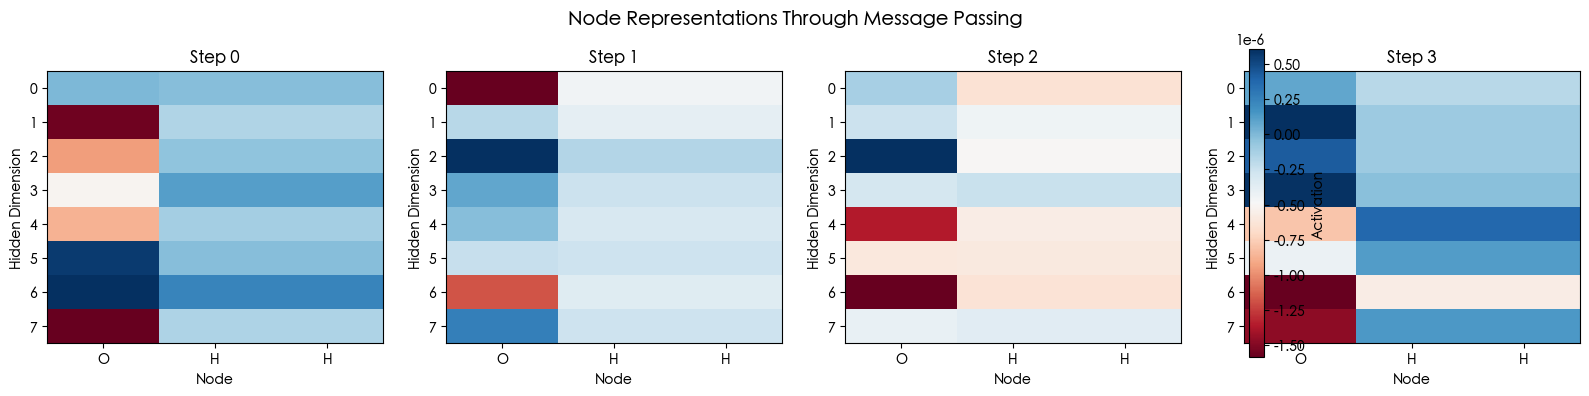


Nodes update their representations by aggregating neighbor information


In [5]:
# Visualize how node representations evolve
fig, axes = plt.subplots(1, len(history), figsize=(16, 4))

for step, states in enumerate(history):
    # Stack node states for visualization
    states_matrix = np.array(states).T  # (hidden_dim, num_nodes)
    
    ax = axes[step]
    im = ax.imshow(states_matrix, cmap='RdBu', aspect='auto')
    ax.set_title(f'Step {step}')
    ax.set_xlabel('Node')
    ax.set_ylabel('Hidden Dimension')
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['O', 'H', 'H'])

plt.colorbar(im, ax=axes, label='Activation')
plt.suptitle('Node Representations Through Message Passing', fontsize=14)
plt.tight_layout()
plt.show()

print("\nNodes update their representations by aggregating neighbor information")

## 创建更复杂的图 (Create More Complex Graph)

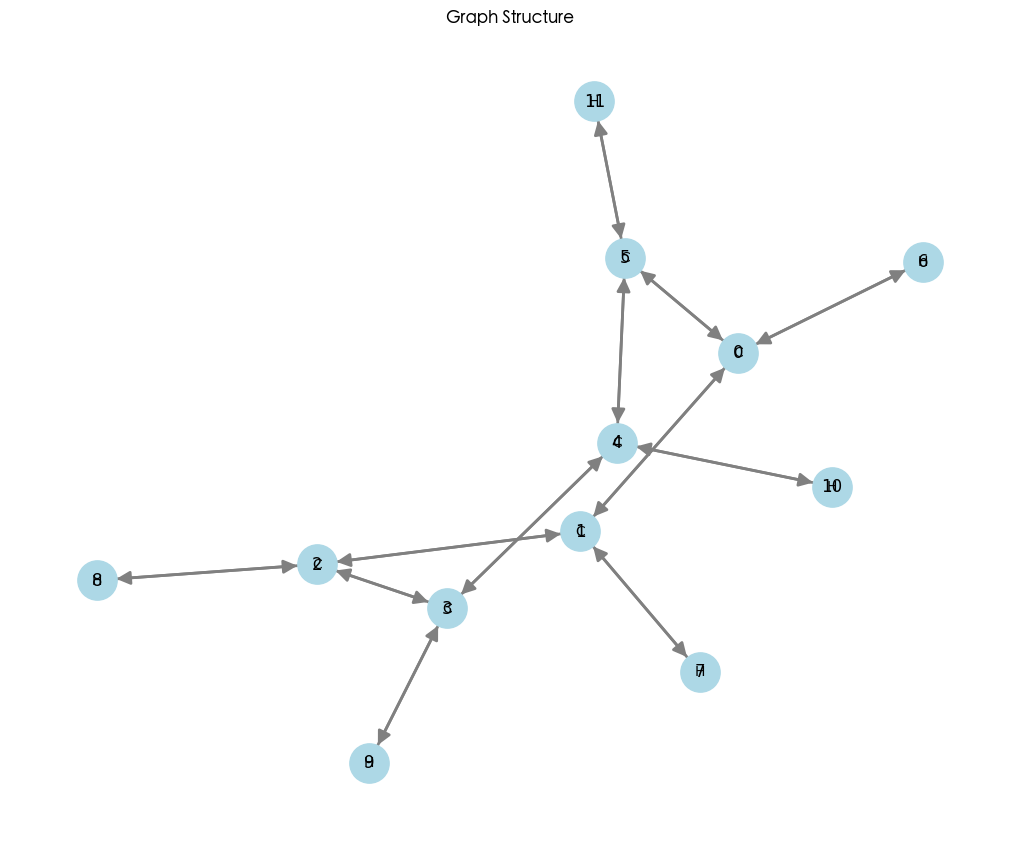


Benzene prediction: [1.71877199e-07]


In [6]:
# Create benzene ring (C6H6)
benzene = Graph(num_nodes=12)  # 6 C + 6 H

# Carbon ring (nodes 0-5)
for i in range(6):
    next_i = (i + 1) % 6
    benzene.add_edge(i, next_i)
    benzene.add_edge(next_i, i)

# Hydrogen atoms (nodes 6-11) attached to carbons
for i in range(6):
    h_idx = 6 + i
    benzene.add_edge(i, h_idx)
    benzene.add_edge(h_idx, i)

# Node features
features = []
for i in range(6):
    features.append(np.array([6, 3]))  # Carbon
for i in range(6):
    features.append(np.array([1, 1]))  # Hydrogen
benzene.set_node_features(features)

# Visualize
labels = {i: 'C' for i in range(6)}
labels.update({i: 'H' for i in range(6, 12)})
benzene.visualize(labels)

# Run MPNN
pred_benzene, hist_benzene = mpnn.forward(benzene)
print(f"\nBenzene prediction: {pred_benzene}")

## 不同的聚合函数 (Different Aggregation Functions)

In [7]:
# Compare aggregation strategies
def sum_aggregation(messages):
    return np.sum(messages, axis=0) if len(messages) > 0 else np.zeros_like(messages[0])

def mean_aggregation(messages):
    return np.mean(messages, axis=0) if len(messages) > 0 else np.zeros_like(messages[0])

def max_aggregation(messages):
    return np.max(messages, axis=0) if len(messages) > 0 else np.zeros_like(messages[0])

# Test on random messages
test_messages = [np.random.randn(8) for _ in range(3)]

print("Aggregation Functions:")
print(f"Sum: {sum_aggregation(test_messages)[:4]}...")
print(f"Mean: {mean_aggregation(test_messages)[:4]}...")
print(f"Max: {max_aggregation(test_messages)[:4]}...")
print("\nDifferent aggregations capture different patterns!")

Aggregation Functions:
Sum: [ 0.57674264  2.02645776 -3.30070788 -3.37211352]...
Mean: [ 0.19224755  0.67548592 -1.10023596 -1.12403784]...
Max: [ 0.4365598   1.37487642 -0.29181127 -0.79919201]...

Different aggregations capture different patterns!


## 关键要点 (Key Takeaways)

### 消息传递框架 (Message Passing Framework)：

**第1阶段：消息传递**（重复T次）
```
对于每个节点 v：
  1. 从邻居收集消息：
     m_v = Σ_{u∈N(v)} M_t(h_v, h_u, e_uv)
  
  2. 更新节点状态：
     h_v = U_t(h_v, m_v)
```

**第2阶段：读出 (Readout)**
```
图表示：
  h_G = R({h_v | v ∈ G})
```

### 组件 (Components)：
1. **消息函数 M**：计算来自邻居的消息
2. **聚合**：组合消息（求和、平均、最大、注意力）
3. **更新函数 U**：更新节点表示
4. **读出 R**：图级池化

### 变体 (Variants)：
- **GCN**：简化的消息传递，带归一化
- **GraphSAGE**：采样邻居，归纳学习
- **GAT**：基于注意力的聚合
- **GIN**：强大的聚合（求和 + MLP）

### 应用 (Applications)：
- **分子性质预测**：QM9、药物发现
- **社交网络**：节点分类、链接预测
- **知识图谱**：推理、补全
- **推荐**：用户-物品图
- **3D视觉**：点云、网格

### 优势 (Advantages)：
- ✅ 处理可变大小的图
- ✅ 排列不变
- ✅ 归纳学习（泛化到新图）
- ✅ 可解释（消息传递）

### 挑战 (Challenges)：
- 过平滑（深层使节点相似）
- 表达能力（受聚合限制）
- 可扩展性（大型图）

### 现代扩展 (Modern Extensions)：
- **图Transformer**：全图上的注意力
- **等变GNN**：尊重对称性 (E(3), SE(3))
- **时序GNN**：动态图
- **异质GNN**：多种节点/边类型